# Quantum Circuit Born Machine (QCBM): 
## Learning and generating Bars and Stripes patterns

1. Explain unsupervised generative learning
2. Explain QCBM
3. Explain Bars and Stripes dataset
4. Implementation and analysis
5. Assess QCBM performance and generalization metrics

0. Connect to QAAS if you want to use Qaptiva.

In [1]:
connect = False  # Set to False if you want to run locally without QLMaaS

if connect:
    from qat.qlmaas import QLMaaSConnection
    conn = QLMaaSConnection(hostname="qlm35e.neasqc.eu", check_host=False)

1. Import the necessary libraries and the self-made QCBM class.

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from myqml import QCBM

2. Define useful functions to generate the bars and stripes dataset

In [3]:
def binary_basis(geometry):
    num_bit = np.prod(geometry)
    M = 2**num_bit
    x = np.arange(M)
    return unpacknbits(x[:,None], num_bit).reshape((-1,)+geometry)

def unpacknbits(arr, nbit, axis=-1):
    '''unpack numbers to bitstrings.'''
    nd = np.ndim(arr)
    if axis < 0:
        axis = nd + axis
    return (((arr & (1 << np.arange(nbit - 1, -1, -1)).reshape([-1] + [1] * (nd - axis - 1)))) > 0).astype('int8')

def barstripe_pdf(geometry):
    '''get bar and stripes PDF'''
    x = binary_basis(geometry)
    pl = is_bs(x)
    return pl/pl.sum()

def is_bs(samples):
    '''a sample is a bar or a stripe.'''
    return (np.abs(np.diff(samples,axis=-1)).sum(axis=(1,2))==0\
           )|((np.abs(np.diff(samples, axis=1)).sum(axis=(1,2)))==0)

def cost(samples):
    '''Cost of a matrix, minimized when for all columns and rows, all their elements are equal'''
    return np.sum(np.minimum(np.abs(np.diff(samples,axis=-1)).sum(axis=(1,2)), np.abs(np.diff(samples, axis=1)).sum(axis=(1,2))))/len(samples)

3. Generate the bars and stripes dataset and plot its histogram

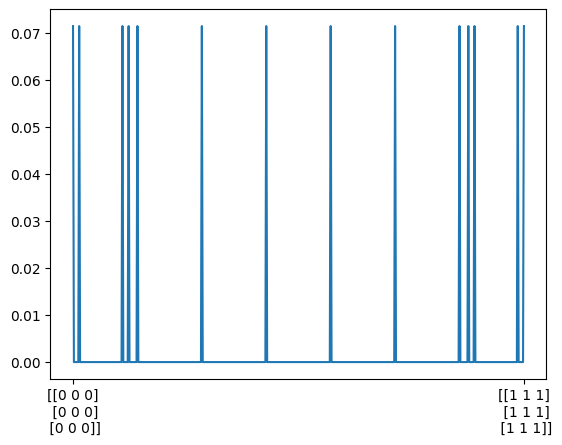

In [4]:
dimension = (3,3)
target_probs = barstripe_pdf(dimension)
plt.plot(target_probs)
# show ticks
basis = binary_basis(dimension)
plt.xticks([0, 2**(dimension[0]*dimension[1]) - 1], [basis[0], basis[2**(dimension[0]*dimension[1]) - 1]])
plt.show = ()

4. Plot all the valid images (bars and stripes)

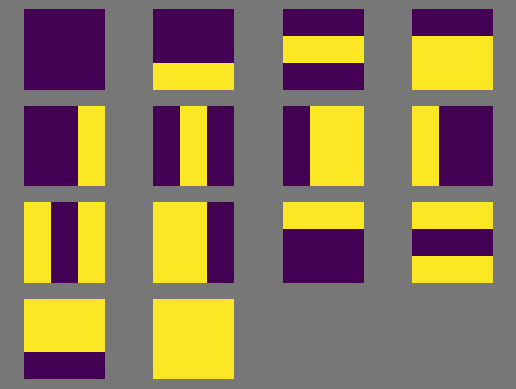

In [5]:
# generate samples
samples = basis[target_probs>1e-2]
n_sols = len(samples)

# show bar and stripes
def plot_bs(samples, size):
    plt.figure(facecolor='#777777')
    gs = plt.GridSpec(*size)

    for i in range(size[0]):
        for j in range(size[1]):
            if i*size[1]+j == len(samples): break
            plt.subplot(gs[i,j]).imshow(samples[i*size[1]+j], vmin=0, vmax=1)
            plt.axis('equal')
            plt.axis('off')
    plt.show = ()

size = (4,4)
plot_bs(samples, size)

5. Define parameters and create an object of the QCBM class

In [ ]:
dimension = (3,3)
n_qubits = np.prod(dimension)
basis = binary_basis(dimension)
basis_flat = basis.reshape(basis.shape[0], -1)
n_blocks = 12
n_shots = 20000
device = 'myQLM'
sigma_list_kernel = [0.5, 1, 2, 4]
method = "L-BFGS-B"

qcbm = QCBM(
    n_qubits=n_qubits,
    basis=basis_flat,
    n_blocks=n_blocks, 
    n_shots=n_shots,
    device=device,
    sigma_list_kernel=sigma_list_kernel,
    dimension=dimension
)


6. Select training data

In [7]:
reweightning = False
remove_samples = False

if reweightning and remove_samples:
    pass
elif not(reweightning) and remove_samples:
    n_removed_valid_samples = 6
    valid_indices = np.where(target_probs > 1e-3)
    chosen_indices = np.random.choice(valid_indices[0], size=n_removed_valid_samples, replace=False)
    target_probs[chosen_indices] = 0.0
    # Renormalize to sum to 1
    target_probs /= target_probs.sum()

    # Print kept matrices
    size = (3,3)
    print("Printing kept valid matrices")
    plot_bs(basis[target_probs > 1e-3], size)


7. Train the QCBM

In [8]:
max_iter = 20
result, tracking_cost, fit_time = qcbm.fit(target_probs=target_probs, method=method, max_iter=max_iter)
print(f"QCBM fitting ended in {fit_time} s")

Step 1, Loss: 0.105613
Step 2, Loss: 0.089439
Step 3, Loss: 0.083340
Step 4, Loss: 0.072634
Step 5, Loss: 0.068379
Step 6, Loss: 0.062650
Step 7, Loss: 0.058558
Step 8, Loss: 0.055720
Step 9, Loss: 0.052421
Step 10, Loss: 0.050989
Step 11, Loss: 0.049877
Step 12, Loss: 0.050118
Step 13, Loss: 0.048249
Step 14, Loss: 0.047487
Step 15, Loss: 0.046887
Step 16, Loss: 0.045733
Step 17, Loss: 0.045838
Step 18, Loss: 0.043804
Step 19, Loss: 0.042807
Step 20, Loss: 0.041457
Optimization using L-BFGS-B completed in 8858.59 seconds.
QCBM fitting ended in 8858.592471837997 s


8. Plot the training loss

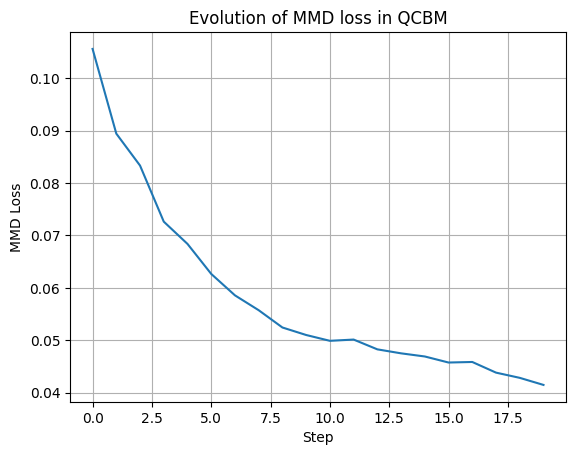

In [9]:
qcbm.plot_loss(tracking_cost)

9. Generate new samples and plot the probability distribution of the generated data

In [1]:
n_gen_samples = 100000
samples_matrix, samples = qcbm.generate_samples(n_gen_samples)
qcbm.plot_generated_distribution(samples)

NameError: name 'qcbm' is not defined

10. Plot some generated samples to see if they are valid

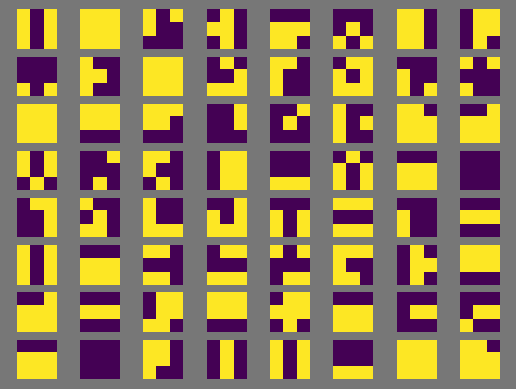

In [11]:
qcbm.plot_generated_samples(samples_matrix[0:64])

11. Calculate the generalization metrics to assess the performance of the QCBM on the bars and stripes dataset

In [12]:
x_tr = basis[target_probs > 1e-3]

metrics = qcbm.calculate_metrics(np.array(samples_matrix), x_tr, is_bs, n_sols, cost)
print("Generalization perfomance of QCBM on Bars and stripes dataset:\n", metrics)

Generalization perfomance of QCBM on Bars and stripes dataset:
 {'precision': 0.3491, 'fidelity': 0.0, 'rate': 0.0, 'coverage': 0.0, 'average cost': 1.3287}
